## DataFrame benchmarks with object vs. string[pyarrow] data

In [1]:
import dask
dask.utils.show_versions()

{
  "Python": "3.11.0",
  "Platform": "Darwin",
  "dask": "2023.3.2",
  "distributed": "2023.3.2",
  "numpy": "1.24.2",
  "pandas": "2.0.0rc1",
  "cloudpickle": "2.2.1",
  "fsspec": "2023.3.0",
  "bokeh": "2.4.3",
  "fastparquet": null,
  "pyarrow": "11.0.0",
  "zarr": null
}

In [2]:
import pandas as pd
import numpy as np
from dask.sizeof import sizeof
from dask.utils import format_bytes
from dask import delayed
import dask.dataframe as dd
import random
import string
from distributed import wait
from distributed import Client
from distributed.diagnostics import MemorySampler
import coiled
import matplotlib
import matplotlib.pyplot as plt
import os
import pyarrow as pa

In [3]:
from dask.distributed import performance_report

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
cluster

LocalCluster(28251ba6, 'tcp://127.0.0.1:61268', workers=4, threads=12, memory=64.00 GiB)

In [5]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61268,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:61280,Total threads: 3
Dashboard: http://127.0.0.1:61284/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:61271,


In [6]:
# partitions in the generated dataframe
npartitions = 50

In [7]:
def random_string():
    return "".join(random.choices(string.printable, k=random.randint(10, 100)))


def random_strings(n, n_unique=None):
    if n_unique is None:
        n_unique = n
    if n == n_unique:
        return (random_string() for _ in range(n_unique))
    choices = [random_string() for _ in range(n_unique)]
    return (random.choice(choices) for _ in range(n))


@delayed(pure=False)
def make_partition(dtype):
    n = 500_000
    n_unique = 500_000
    df = pd.DataFrame({
        "name": pd.Series(random_strings(n, n_unique), dtype=dtype)
    })
    return df

In [8]:
def get_ddf(persist=False, file_name="data1.parquet"):
    if not os.path.exists(file_name):
        # make some fake data
        meta = pd.DataFrame({"name": pd.Series([], dtype=object)})
        ddf = dd.from_delayed(
            [make_partition(object) for i in range(npartitions)],
            meta=meta
        )
        # store it
        ddf.to_parquet(file_name, engine="pyarrow", overwrite=True)
    # then read it
    ddf = dd.read_parquet(file_name, engine="pyarrow")
    return ddf.persist() if persist else ddf

In [9]:
def get_ddf2(persist=False, file_name="data2.parquet"):
    if not os.path.exists(file_name):
        meta = pd.DataFrame({"name": pd.Series([], dtype="string[pyarrow]")})
        ddf = dd.from_delayed(
            [make_partition("string[pyarrow]") for i in range(npartitions)],
            meta=meta
        )
        schema = {"name": pa.string()}
        ddf.to_parquet(file_name, engine="pyarrow", overwrite=True)
    with dask.config.set({"dataframe.convert_string": True}):
        ddf = dd.read_parquet(file_name, engine="pyarrow")
    return ddf.persist() if persist else ddf

## Memory usage

In [10]:
from dask.utils import format_bytes

In [11]:
client.restart();

2023-03-31 16:18:22,805 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:18:22,814 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:18:22,815 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:18:22,816 - distributed.nanny - WARNING - Restarting worker


In [10]:
ddf = get_ddf(True)

In [11]:
# ddf.size.compute()

In [12]:
ddf.dtypes

name    object
dtype: object

In [13]:
ddf.head(10)

,name
0,"q""7iT.ORr:[S+Yj[y%}6dew(^6 7h-Yw~Vz3#wYU"
1,">)k$FPJ5i4553:z2w\t>Na)!vn*e ZF6]`6UW %q,{(zHM..."
2,"~ /IX0W9U.4UZl_0O{BJj1,T:{J<Wqc )aSgI4N:qpW\n..."
3,"R5 T5Q32>BdE,>h.,?:_r+d.AQAh^B 0WoG$gPu7]je"
4,"_1KNo4MSQD]i[N,cAW!,;-U|""3L%6jX;}j/^oNZNL( ])l..."
5,'. FSAY\t<%^9!]S|pNHdGZ3%
6,$QW(~3.{xoHT.\0 ?Y2lF+ARhn1<Ayl$Umqsb\t=+'=b`h...
7,Qrepzx A'[
8,tP`L<]8k>5HM']fOF0JPX\t]@:H`v
9,FlX]O^G&cC!B$XKsKxh76\tvza_2iRPC4U(\nfj=[$E3$+...


In [14]:
format_bytes(ddf.memory_usage(deep=True).sum().compute())

'572.19 MiB'

In [15]:
memory_usage_object = ddf.memory_usage_per_partition(deep=True).compute().apply(format_bytes)
memory_usage_object

0     11.43 MiB
1     11.44 MiB
2     11.43 MiB
3     11.44 MiB
4     11.45 MiB
5     11.46 MiB
6     11.44 MiB
7     11.43 MiB
8     11.44 MiB
9     11.45 MiB
10    11.43 MiB
11    11.45 MiB
12    11.46 MiB
13    11.44 MiB
14    11.44 MiB
15    11.44 MiB
16    11.45 MiB
17    11.44 MiB
18    11.43 MiB
19    11.44 MiB
20    11.45 MiB
21    11.44 MiB
22    11.45 MiB
23    11.44 MiB
24    11.44 MiB
25    11.46 MiB
26    11.44 MiB
27    11.44 MiB
28    11.45 MiB
29    11.45 MiB
30    11.45 MiB
31    11.45 MiB
32    11.45 MiB
33    11.43 MiB
34    11.43 MiB
35    11.46 MiB
36    11.45 MiB
37    11.43 MiB
38    11.46 MiB
39    11.44 MiB
40    11.45 MiB
41    11.43 MiB
42    11.44 MiB
43    11.43 MiB
44    11.45 MiB
45    11.44 MiB
46    11.45 MiB
47    11.45 MiB
48    11.45 MiB
49    11.44 MiB
dtype: object

In [16]:
client.restart();

2023-03-31 16:27:22,315 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:22,326 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:22,327 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:22,328 - distributed.nanny - WARNING - Restarting worker


In [17]:
ddf2 = get_ddf2(True)

In [18]:
ddf2.dtypes

name    string[pyarrow]
dtype: object

In [19]:
format_bytes(ddf2.memory_usage(deep=True).sum().compute())

'319.49 MiB'

In [20]:
memory_usage_string = ddf2.memory_usage_per_partition().compute().apply(format_bytes)
memory_usage_string

0     6.40 MiB
1     6.39 MiB
2     6.39 MiB
3     6.40 MiB
4     6.39 MiB
5     6.39 MiB
6     6.39 MiB
7     6.38 MiB
8     6.39 MiB
9     6.39 MiB
10    6.39 MiB
11    6.39 MiB
12    6.40 MiB
13    6.40 MiB
14    6.38 MiB
15    6.39 MiB
16    6.39 MiB
17    6.38 MiB
18    6.39 MiB
19    6.41 MiB
20    6.39 MiB
21    6.38 MiB
22    6.38 MiB
23    6.39 MiB
24    6.39 MiB
25    6.38 MiB
26    6.39 MiB
27    6.39 MiB
28    6.39 MiB
29    6.39 MiB
30    6.39 MiB
31    6.38 MiB
32    6.40 MiB
33    6.38 MiB
34    6.40 MiB
35    6.37 MiB
36    6.39 MiB
37    6.38 MiB
38    6.38 MiB
39    6.40 MiB
40    6.39 MiB
41    6.40 MiB
42    6.39 MiB
43    6.39 MiB
44    6.38 MiB
45    6.39 MiB
46    6.39 MiB
47    6.39 MiB
48    6.39 MiB
49    6.38 MiB
dtype: object

## Running time

In [21]:
client.restart();

2023-03-31 16:27:52,297 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:52,312 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:52,314 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:27:52,315 - distributed.nanny - WARNING - Restarting worker


In [43]:
ddf = get_ddf(True)

In [44]:
wait(ddf);

In [45]:
%timeit -r 5 -n 2 ddf.name.unique().compute()

690 ms ± 185 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [46]:
%timeit -r 5 -n 2 ddf.groupby("name").count().compute()

677 ms ± 193 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [47]:
%timeit -r 5 -n 2 ddf.name.str.startswith("a").compute()

2.72 s ± 22 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [48]:
%timeit -r 5 -n 2 ddf.name.str.len().compute()

2.78 s ± 14 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [50]:
client.restart();

2023-03-31 15:59:35,655 - distributed.nanny - WARNING - Restarting worker
2023-03-31 15:59:35,668 - distributed.nanny - WARNING - Restarting worker
2023-03-31 15:59:35,670 - distributed.nanny - WARNING - Restarting worker
2023-03-31 15:59:35,670 - distributed.nanny - WARNING - Restarting worker


In [51]:
ddf2 = get_ddf2(True)

In [52]:
wait(ddf2);

In [53]:
%timeit -r 5 -n 2 ddf2.name.unique().compute()

The slowest run took 9.58 times longer than the fastest. This could mean that an intermediate result is being cached.
315 ms ± 152 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [54]:
%timeit -r 5 -n 2 ddf2.groupby("name").count().compute()

515 ms ± 4.95 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [55]:
%timeit -r 5 -n 2 ddf2.name.str.startswith("a").compute()

1.03 s ± 25 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [56]:
%timeit -r 5 -n 2 ddf2.name.str.len().compute()

1.56 s ± 15.4 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Create memory samplers and store benchmarks

In [11]:
ms1 = MemorySampler()
ms2 = MemorySampler()
ms3 = MemorySampler()
ms4 = MemorySampler()

In [12]:
report_dir = "performance/local4workers3"

In [13]:
import time

## Benchmark 1

In [16]:
client.restart();

2023-03-31 16:53:46,152 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:53:46,168 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:53:46,170 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:53:46,170 - distributed.nanny - WARNING - Restarting worker


In [17]:
ddf = get_ddf(True)

In [18]:
# 1
with performance_report(filename=f"{report_dir}/1-object-unique.html"):
    with ms1.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.unique().count().compute()
            time.sleep(0.2)

In [21]:
client.restart();

2023-03-31 16:56:12,215 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:56:12,241 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:56:12,242 - distributed.nanny - WARNING - Restarting worker
2023-03-31 16:56:12,248 - distributed.nanny - WARNING - Restarting worker


In [22]:
ddf2 = get_ddf2(True)

In [23]:
# 1, ddf2
with performance_report(filename=f"{report_dir}/1-string-unique.html"):
    with ms1.sample("arrow string", interval=0.01):
        for _ in range(5):
            ddf2.name.unique().count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Unique/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

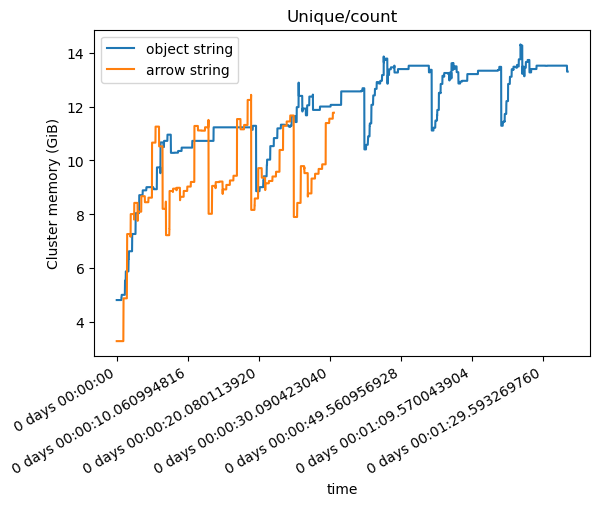

In [24]:
ms1.plot(align=True, title="Unique/count")

## Benchmark 2

In [32]:
client.restart();

2023-03-31 17:02:19,102 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:02:19,138 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:02:19,139 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:02:19,148 - distributed.nanny - WARNING - Restarting worker


In [33]:
ddf = get_ddf(True)

In [34]:
# 2
with performance_report(filename=f"{report_dir}/2-object-group-count.html"):
    with ms2.sample("object string", interval=0.01):
        for _ in range(1):
            ddf.groupby("name").count().compute()
            time.sleep(0.2)

In [35]:
client.restart();

2023-03-31 17:03:08,902 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:03:08,950 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:03:08,952 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:03:08,954 - distributed.nanny - WARNING - Restarting worker


In [36]:
ddf2 = get_ddf2(True)

In [37]:
# 2, ddf2
with performance_report(filename=f"{report_dir}/2-string-group-count.html"):
    with ms2.sample("arrow string", interval=0.01):
        for _ in range(1):
            ddf2.groupby("name").count().compute()
            time.sleep(0.2)

<Axes: title={'center': 'Groupby/count'}, xlabel='time', ylabel='Cluster memory (GiB)'>

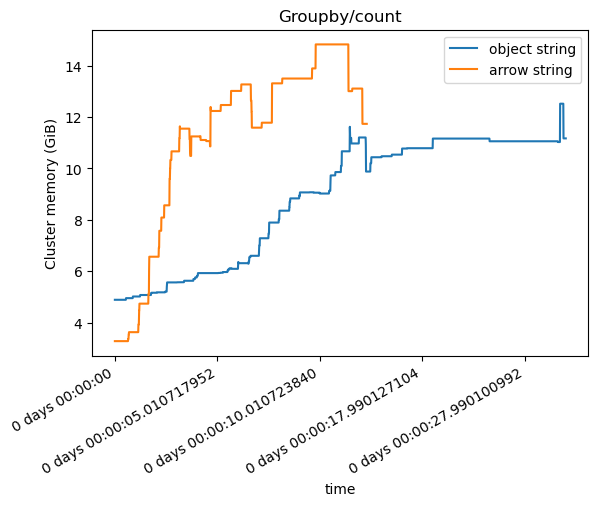

In [38]:
ms2.plot(align=True, title="Groupby/count")

## Benchmark 3

In [39]:
client.restart();

2023-03-31 17:04:02,548 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:02,587 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:02,588 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:02,589 - distributed.nanny - WARNING - Restarting worker


In [40]:
ddf = get_ddf(True)

In [41]:
# 3
with performance_report(filename=f"{report_dir}/3-object-startswith.html"):
    with ms3.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.str.startswith("a").compute()
            time.sleep(0.2)

In [42]:
client.restart();

2023-03-31 17:04:25,668 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:25,670 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:25,692 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:25,693 - distributed.nanny - WARNING - Restarting worker


In [43]:
ddf2 = get_ddf2(True)

In [44]:
# 3, ddf2
with performance_report(filename=f"{report_dir}/3-string-startswith.html"):
    with ms3.sample("arrow string", interval=0.01):
        for _ in range(5):
            get_ddf2(True).name.str.startswith("a").compute()
            time.sleep(0.2)

<Axes: title={'center': 'String startswith'}, xlabel='time', ylabel='Cluster memory (GiB)'>

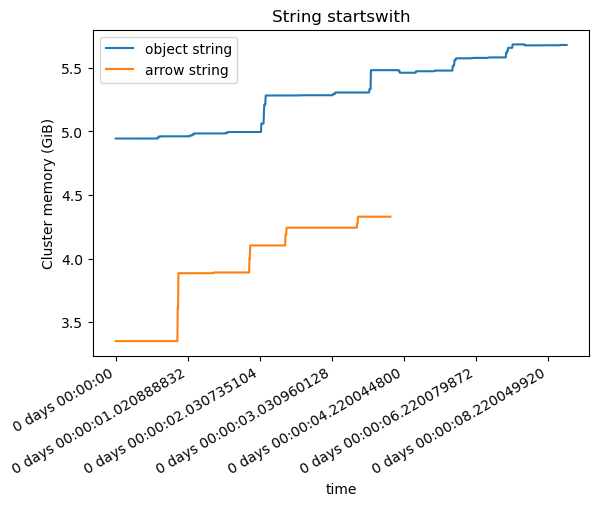

In [45]:
ms3.plot(align=True, title="String startswith")

## Benchmark 4

In [46]:
client.restart();

2023-03-31 17:04:49,682 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:49,718 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:49,720 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:04:49,724 - distributed.nanny - WARNING - Restarting worker


In [47]:
ddf = get_ddf(True)

In [48]:
# 4
with performance_report(filename=f"{report_dir}/4-object-strlen.html"):
    with ms4.sample("object string", interval=0.01):
        for _ in range(5):
            ddf.name.str.len().compute()
            time.sleep(0.2)

In [49]:
client.restart();

2023-03-31 17:05:09,762 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:05:09,784 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:05:09,785 - distributed.nanny - WARNING - Restarting worker
2023-03-31 17:05:09,787 - distributed.nanny - WARNING - Restarting worker


In [50]:
ddf2 = get_ddf2(True)

In [51]:
# 4, ddf2
with performance_report(filename=f"{report_dir}/4-string-strlen.html"):
    with ms4.sample("arrow string", interval=0.01):
        for _ in range(5):
            ddf2.name.str.len().compute()
            time.sleep(0.2)

<Axes: title={'center': 'String length'}, xlabel='time', ylabel='Cluster memory (GiB)'>

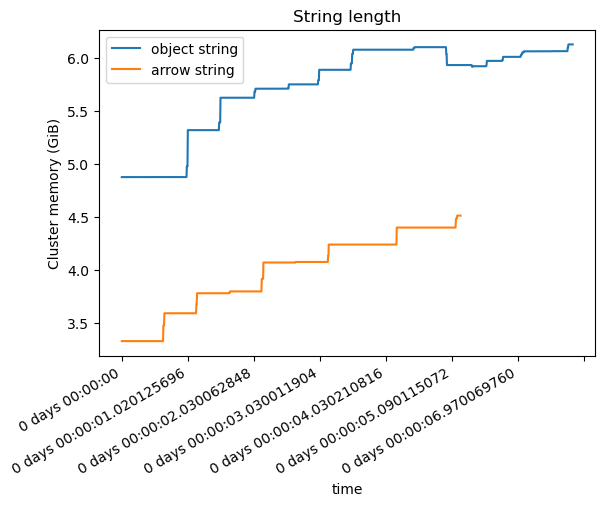

In [52]:
ms4.plot(align=True, title="String length")

In [53]:
client.close()

In [54]:
cluster.close()